In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import defaultdict
import random
from typing import Tuple, Optional
from data_structures import PatientData
from decoders import ConceptDataset # Make sure this is accessible


In [3]:


# Assuming PatientData and ConceptDataset classes are defined as in your files

def visualize_temporal_blocks(
    patient_data: PatientData,
    concept_pair: Tuple[str, str],
    T_separation: Optional[float] = None,
    test_size: Optional[float] = None,
    figsize: Tuple[int, int] = (18, 5),
    s: int = 50, # marker size
    alpha: float = 0.8
):
    """
    Visualizes the temporal blocks created for a concept pair decoding task.

    Args:
        patient_data: An initialized PatientData object.
        concept_pair: A tuple containing two concept strings (e.g., ('J.Bauer', 'C.OBrian')).
        T_separation: Minimum time gap for block separation. If None, uses default (21.0).
        test_size: Target fraction for the test set. If None, uses default (0.3).
        figsize: Size of the matplotlib figure.
        s: Marker size for scatter plot.
        alpha: Marker transparency.

    Returns:
        matplotlib.figure.Figure, matplotlib.axes._axes.Axes: The figure and axes objects.
    """
    # --- 1. Determine Parameters ---
    # Use defaults from ConceptDataset if not provided
    effective_T_separation = T_separation if T_separation is not None else 21.0
    effective_test_size = test_size if test_size is not None else 0.3

    print(f"Visualizing blocks for {concept_pair} | Patient: {patient_data.pid}")
    print(f"Using T_separation = {effective_T_separation}s, test_size = {effective_test_size}")

    # --- 2. Gather Real Data and Onset Times ---
    c1, c2 = concept_pair
    try:
        # Get exclusive onset times for each concept
        c1_onset_times = patient_data.exclusive_movie_times(c1=c1, c2=c2)
        c2_onset_times = patient_data.exclusive_movie_times(c1=c2, c2=c1)

        # Check minimum samples (use dataset's min_samples logic if available, else hardcode a reasonable check)
        min_samples_check = 1 # Need at least one sample to plot anything
        if len(c1_onset_times) < min_samples_check or len(c2_onset_times) < min_samples_check:
             print(f"Warning: Insufficient samples for one or both concepts.")
             # Decide how to handle - maybe plot what we have or raise error?
             # For now, we'll try to proceed if *any* data exists

        # Combine onset times and create corresponding concept IDs and labels
        onset_times = np.concatenate([c1_onset_times, c2_onset_times])
        concept_ids = np.array([c1] * len(c1_onset_times) + [c2] * len(c2_onset_times))
        y = np.concatenate([np.zeros(len(c1_onset_times)), np.ones(len(c2_onset_times))]) # Labels for split (not plotted)
        X_dummy = np.zeros((len(onset_times), 1)) # Dummy X data needed for split function signature

        if len(onset_times) == 0:
            raise ValueError("No exclusive onset times found for the given pair.")

    except ValueError as e:
        print(f"Error gathering data: {e}")
        return None, None

    # --- 3. Reconstruct Temporal Blocks and Assignments ---
    # Instantiate dataset temporarily to use its split method
    # NOTE: This assumes ConceptDataset can be instantiated and _temporal_block_split accessed
    # If _temporal_block_split is complexly tied to internal state, may need to copy its logic here.
    try:
        temp_dataset = ConceptDataset(
            patient_data=patient_data,
            concepts_groups=concept_pair,
            epoch='movie', # Assuming movie epoch
            neurons=patient_data.neurons # Assuming use all neurons for time finding
        )
        train_indices, test_indices = temp_dataset._temporal_block_split(
            X_dummy, y, onset_times,
            test_size=effective_test_size,
            T_separation=effective_T_separation
        )
        train_indices_set = set(train_indices)
        test_indices_set = set(test_indices)

    except Exception as e:
         print(f"Error during temporal split simulation: {e}")
         print("Cannot determine block assignments. Check ConceptDataset/_temporal_block_split.")
         return None, None


    # Re-run block finding logic to get block structure
    n_samples = len(onset_times)
    original_indices = np.arange(n_samples)
    if n_samples == 0: # Handle empty case explicitly
        print("No samples to process.")
        return plt.figure(figsize=figsize), plt.gca() # Return empty plot

    sorted_indices = np.argsort(onset_times)
    sorted_onsets = onset_times[sorted_indices]
    sorted_original_indices = original_indices[sorted_indices]

    adj = defaultdict(list)
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if sorted_onsets[j] - sorted_onsets[i] < effective_T_separation:
                adj[i].append(j)
                adj[j].append(i)
            else:
                break # Optimization for sorted list

    visited = set()
    blocks_sorted_indices = [] # List of blocks (each block = list of sorted indices)
    for i in range(n_samples):
        if i not in visited:
            component = []
            q = [i]
            visited.add(i)
            while q:
                u = q.pop(0) # BFS
                component.append(u)
                for v in adj[u]:
                    if v not in visited:
                        visited.add(v)
                        q.append(v)
            blocks_sorted_indices.append(component)

    # Map sorted block indices back to original sample indices
    original_indices_blocks = []
    for block in blocks_sorted_indices:
        original_indices_blocks.append(list(sorted_original_indices[block]))

    # Assign train/test label to each block and create mapping for original indices
    index_to_block_id = {}
    index_to_assignment = {}
    block_assignments = [] # To store 'train' or 'test' for each block
    print(f"Found {len(original_indices_blocks)} temporal blocks.")

    for block_id, block_orig_indices in enumerate(original_indices_blocks):
        if not block_orig_indices: continue # Skip empty blocks if they somehow occur

        # Determine assignment based on the first index (all should be same)
        first_idx = block_orig_indices[0]
        assignment = 'train' if first_idx in train_indices_set else 'test'
        block_assignments.append(assignment)

        # Check consistency (optional but good)
        # assert all((idx in train_indices_set) == (first_idx in train_indices_set) for idx in block_orig_indices), \
        #     f"Inconsistent assignment within block {block_id}!"

        # Map original indices
        for idx in block_orig_indices:
            index_to_block_id[idx] = block_id
            index_to_assignment[idx] = assignment

    n_blocks = len(original_indices_blocks)
    print(f"Assigned {block_assignments.count('train')} blocks to Train, {block_assignments.count('test')} blocks to Test.")
    print(f"Resulting split: {len(train_indices)} Train samples, {len(test_indices)} Test samples.")


    # --- 4. Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    colors = cm.viridis(np.linspace(0, 1, n_blocks)) # Colormap for blocks

    # Store handles for legend
    legend_elements = {
        'train': plt.Line2D([0], [0], marker='o', color='grey', label='Train', linestyle='None', markersize=8),
        'test': plt.Line2D([0], [0], marker='x', color='grey', label='Test', linestyle='None', markersize=8, mew=2) # mew for thicker 'x'
    }

    plotted_blocks = set() # To avoid adding block colors multiple times to legend

    for i in range(n_samples):
        time = onset_times[i]
        concept = concept_ids[i]
        block_id = index_to_block_id.get(i, -1) # Default to -1 if index missing
        assignment = index_to_assignment.get(i, 'unassigned')

        if block_id == -1:
             print(f"Warning: Index {i} not found in any block.")
             continue

        y_val = 1 if concept == c1 else -1
        marker = 'o' if assignment == 'train' else 'x'
        color = colors[block_id % len(colors)] # Use modulo in case block_id is out of range (shouldn't happen)
        mew = 0.5 if marker == 'o' else 2 # Marker edge width

        # Add block color to legend only once
        if block_id not in plotted_blocks:
             # uncomment below to add block colors to legend (can get crowded)
             # legend_elements[f'block_{block_id}'] = plt.Line2D([0], [0], marker='s', color=color, label=f'Block {block_id}', linestyle='None', markersize=8)
             plotted_blocks.add(block_id)

        ax.scatter(time, y_val, c=[color], marker=marker, s=s, alpha=alpha, linewidths=mew, edgecolors='black' if marker=='o' else color)


    # --- 5. Formatting ---
    ax.set_yticks([-1, 1])
    ax.set_yticklabels([c2, c1])
    ax.set_xlabel("Time in Movie (seconds, relative to recording start)")
    ax.set_ylabel("Concept")
    ax.set_title(f"Temporal Blocks for '{c1}' vs '{c2}' (Patient {patient_data.pid})\n"
                 f"T_separation={effective_T_separation}s | Colors=Block ID | Marker=Train/Test")
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.axhline(0, color='black', linewidth=0.5) # Line separating concepts

    # Add legend for train/test markers
    ax.legend(handles=legend_elements.values(), loc='upper right')

    # Adjust x-limits for better visualization
    if len(onset_times) > 0:
        min_time = np.min(onset_times)
        max_time = np.max(onset_times)
        time_range = max_time - min_time
        ax.set_xlim(min_time - time_range * 0.05, max_time + time_range * 0.05)
    else:
        # Set some default limits if no data
         ax.set_xlim(0, 100) # Arbitrary default

    plt.tight_layout()
    return fig, ax

# Example Usage (replace with your actual data loading):
# Make sure you have initialized p563 correctly before this
# try:
#     p563 = PatientData(pid='563') # Or load from where you have it
#     concept_pair_to_plot = ('J.Bauer', 'C.OBrian')
#     fig, ax = visualize_temporal_blocks(
#         patient_data=p563,
#         concept_pair=concept_pair_to_plot,
#         T_separation=21.0, # Optional: override default
#         test_size=0.3     # Optional: override default
#     )
#     if fig:
#         plt.show()
# except NameError:
#      print("Please ensure 'PatientData' class is defined and 'p563' object is initialized.")
# except Exception as e:
#      print(f"An error occurred during plotting: {e}")

./Data/40m_act_24_S06E01_30fps_character_frames.csv
Visualizing blocks for ('J.Bauer', 'C.OBrian') | Patient: 563
Using T_separation = 21.0s, test_size = 0.3
Found 16 temporal blocks.
Assigned 9 blocks to Train, 7 blocks to Test.
Resulting split: 119 Train samples, 51 Test samples.


/var/folders/9c/4b964bn507zc652npm2l2ch80000gn/T/ipykernel_56153/4083654828.py:189: UserWarning: You passed a edgecolor/edgecolors (array([0.190631, 0.407061, 0.556089, 1.      ])) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(time, y_val, c=[color], marker=marker, s=s, alpha=alpha, linewidths=mew, edgecolors='black' if marker=='o' else color)
/var/folders/9c/4b964bn507zc652npm2l2ch80000gn/T/ipykernel_56153/4083654828.py:189: UserWarning: You passed a edgecolor/edgecolors (array([0.327796, 0.77398 , 0.40664 , 1.      ])) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(time, y_val, c=[color], marker=marker, s=s, alpha=alpha, linewidths=mew, edgecolors='black' if marker=='o' else color)
/var/folders/9c/4b964bn507zc652npm2l2ch80000gn/T/ipykernel_56153/4083654828.py:189: UserWarning: You p

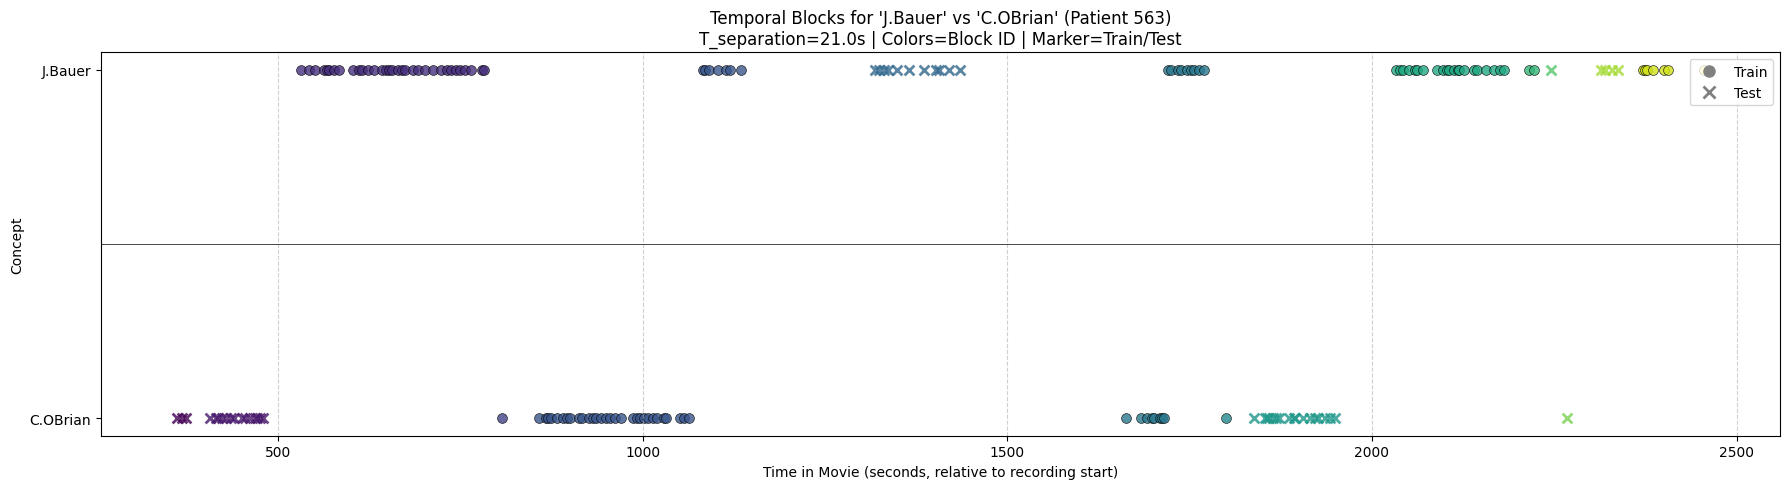

In [ ]:
p563 = PatientData(pid='563')
concept_pair_to_plot = ('J.Bauer', 'C.OBrian') # Choose your pair
fig, ax = visualize_temporal_blocks(
    patient_data=p563,
    concept_pair=concept_pair_to_plot
)
if fig:
    plt.show()

Visualizing blocks for ('J.Bauer', 'A.Fayed') | Patient: 563
Using T_separation = 21.0s, test_size = 0.3
Found 9 temporal blocks.
Assigned 4 blocks to Train, 5 blocks to Test.
Resulting split: 66 Train samples, 40 Test samples.


/var/folders/9c/4b964bn507zc652npm2l2ch80000gn/T/ipykernel_56153/4083654828.py:189: UserWarning: You passed a edgecolor/edgecolors (array([0.229739, 0.322361, 0.545706, 1.      ])) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(time, y_val, c=[color], marker=marker, s=s, alpha=alpha, linewidths=mew, edgecolors='black' if marker=='o' else color)
/var/folders/9c/4b964bn507zc652npm2l2ch80000gn/T/ipykernel_56153/4083654828.py:189: UserWarning: You passed a edgecolor/edgecolors (array([0.172719, 0.448791, 0.557885, 1.      ])) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(time, y_val, c=[color], marker=marker, s=s, alpha=alpha, linewidths=mew, edgecolors='black' if marker=='o' else color)
/var/folders/9c/4b964bn507zc652npm2l2ch80000gn/T/ipykernel_56153/4083654828.py:189: UserWarning: You p

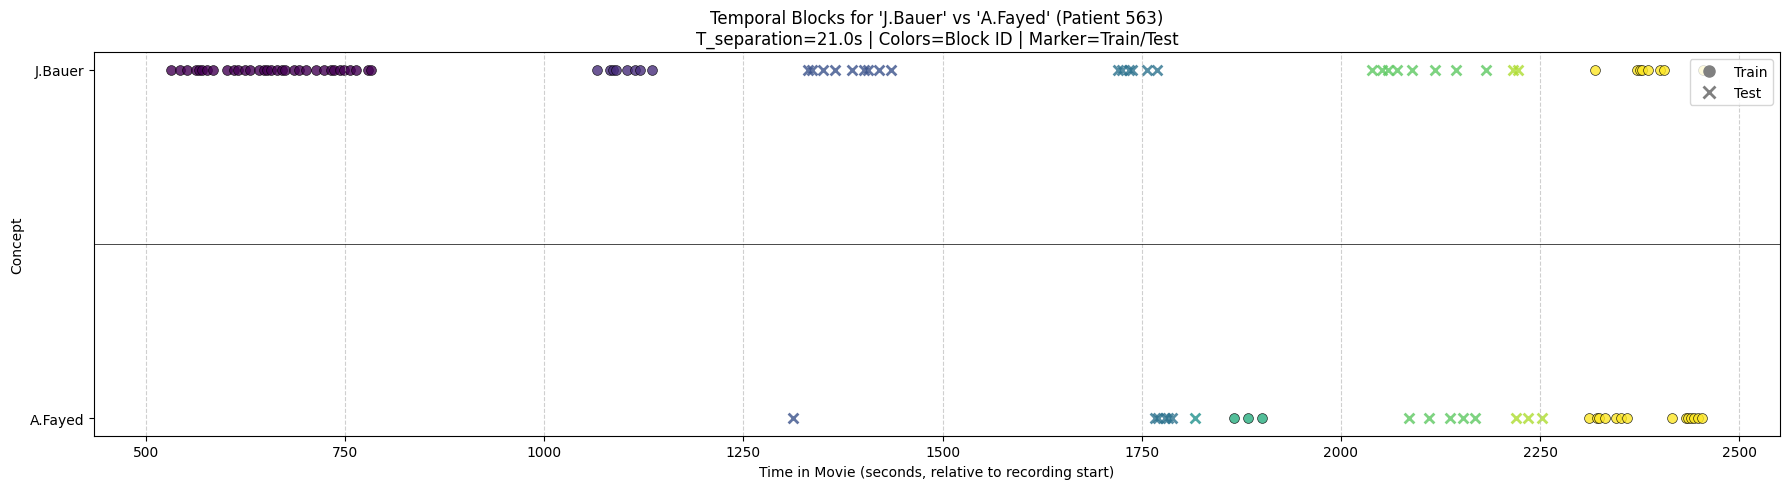

In [7]:
concept_pair_to_plot = ('J.Bauer', 'A.Fayed') # Choose your pair
fig, ax = visualize_temporal_blocks(
    patient_data=p563,
    concept_pair=concept_pair_to_plot
)
if fig:
    plt.show()